# TẠO CÁC TẬP DỮ LIỆU TRAIN, TEST (SPLITS)

1. Yêu cầu chung: Tạo ra các splits, mỗi split tương ứng với một tập dữ liệu train - test
   
  + Bài học lý thuyết (để trả lời cho các câu hỏi như vì sao phải cần việc này, thực hiện việc này như thế nào):
    
    - https://www.kaggle.com/code/satishgunjal/tutorial-k-fold-cross-validation
      
    - https://machinelearningmastery.com/training-validation-test-split-and-cross-validation-done-right/
   
    - https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/

  <IMG SRC = 'https://raw.githubusercontent.com/satishgunjal/images/master/KFold_Cross_Validation.png'>
  
2. Yêu cầu cụ thể:
   
- Input:
    + Thư mục cha chứa các thư mục con - mỗi thư mục con tương ứng với tên của từng hiệu xe (Honda, Suzuki, VinFast, Yamaha, Others). Ví dụ: https://drive.google.com/drive/u/1/folders/1Uj0V9URNHpzSHeXHSB89AoGCjGki8Yra
      
    + Các ảnh được đặt tên theo quy ước: các tập tin ảnh theo quy ước
 
    + Số splits NumSplits - mặc định NumSplits=5 (tương đương 5-fold CV)
 
- Output:

    + File CarDataset.csv - Tập tin chứa tất cả ảnh của dataset
      
      - Chương trình sẽ scan qua cây thư mục để tìm tất cả các ảnh (chỉ chọn các ảnh có định dạng + phần mở rộng là .jpg)
        
      - Mỗi dòng sẽ có các thông tin cách nhau bằng dấu phẩy, theo quy ước: ImageFullPath, CategoryID
     
            - ImageFullPath ở dạng <Thư mục Hiệu xe>/<Tên ảnh>. Ví dụ: Honda/2024123.Honda.1.jpg.
            - CategoryID là số nguyên thuộc [0..5] theo quy ước
              - 0: Others
              - 1: Honda
              - 2: Suzuki
              - 3: Yamaha
              - 4: VinFast
     
    + File CarDataset-Splits-[1..5]-[Train/Test].csv - Phân chia thành các splits, mỗi split gồm các ảnh được chia thành thành 2 tập Train - Test
 
      
      + Chương trình sẽ đọc dữ liệu từ file CarDataset.csv, sau đó với mỗi hiệu xe, chia ngẫu nhiên thành 5 tập dữ liệu. Lưu ý là phải chia theo hiệu xe, để đảm bảo dữ liệu Train/Test có dữ liệu của các hiệu xe.
        
      + Từ 5 tập dữ liệu chia ngẫu nhiên theo các hiệu xe Xij (i là thứ tự tập dữ liệu, j là CategoryID), gom lại thành 5 tập dữ liệu lớn hơn Xi, sao cho mỗi tập dữ liệu này chứa đủ dữ liệu của tất cả các hiệu xe. Tức là Xi = Union(Xij)
     
      + Từ 5 tập dữ liệu Xi này (tương ứng với FOLDi ở trong hình vẽ trên), tạo ra 5 splits Split-i
     
      + Với mỗi bộ dữ liệu Split-i, ghi xuống thành 2 tập tin tương ứng với Train, Test. Ví dụ Split-1 thì ghi thành tập tin  CarDataset-Splits-1-Train.csv và CarDataset-Splits-1-Test.csv. Tập Train gồm 4 bộ, Test gồm bộ còn lại. Ví dụ,
     
          + Split-1: tập Train sẽ gồm X2, X3, X4, X5, tập Test là X1
            
          + Split-5: tập Train sẽ gồm X1, X2, X3, X4, tập Test là X5
       
      + Mỗi dòng sẽ có các thông tin cách nhau bằng dấu phẩy, theo quy ước: ImageFullPath, CategoryID
     
- Lưu ý:

  - Nên viết thêm các cell
    
    - Hiển thị danh sách các tên tập tin ảnh trong từng Split-Train/Test,
      
    - Thống kê các ảnh cho từng CategoryID trong mỗi Split-Train/Test
   
  - Cần có chú thích
 
3. Nộp bài: SV share notebook. Các bài nộp sớm sẽ được full điểm. Deadline: TBA
   
5. Bài làm đạt yêu cầu sẽ được paste vào notebook với ghi nhận đóng góp từ tác giả.

## Thông tin của tác giả, ngày cập nhật

* Nguyễn Thành Vinh - 22521676
* Nguyễn Đình Vũ - 22521692

Ngày cập nhật: 15/1/2024

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import KFold
import csv
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
import os
import pandas as pd
from sklearn.model_selection import KFold
import re

class CarDatasetSplitter:
    def __init__(self, root_dir, output_dir, num_splits=5):
        self.root_dir = root_dir
        self.output_dir = output_dir
        self.num_splits = num_splits
        self.category_mapping = {
            'Others': 0,
            'Honda': 1,
            'Hyundai': 2,
            'KIA': 3,
            'Mazda': 4,
            'Mitsubishi': 5,
            'Suzuki': 6,
            'Toyota': 7,
            'VinFast': 8
        }
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

    def is_valid_filename(self, filename, category):
        """
        Kiểm tra tên file có đúng format không sử dụng regex
        Format: mssv1-mssv2-mssv3.category.count.{jpg,png,jpeg}
        """
        # Pattern giải thích:
        # ^                   : bắt đầu chuỗi
        # [\w-]+             : một hoặc nhiều ký tự chữ/số/gạch dưới và dấu gạch ngang cho phần MSSV
        # \.                 : dấu chấm (phải escape)
        # {category}         : tên category (sẽ được format sau)
        # \.                 : dấu chấm
        # \d+               : một hoặc nhiều chữ số cho count
        # \.(jpg|jpeg|png)$ : kết thúc bằng .jpg hoặc .jpeg hoặc .png (case insensitive)
        pattern = f"^[\w-]+\.{category}\.\d+\.(jpg|jpeg|png)$"
        
        # re.match sẽ trả về None nếu không khớp pattern
        # re.IGNORECASE để không phân biệt hoa thường cho phần đuôi file
        return bool(re.match(pattern, filename, re.IGNORECASE))

    def scan_dataset(self):
        """Scan through directory structure and create main dataset CSV"""
        data = []
        for category in self.category_mapping.keys():
            category_path = os.path.join(self.root_dir, category)
            if not os.path.exists(category_path):
                continue
            
            for img_file in os.listdir(category_path):
                # Chỉ thêm file nếu tên file hợp lệ
                if self.is_valid_filename(img_file, category):
                    relative_path = os.path.join(category, img_file)
                    category_id = self.category_mapping[category]
                    data.append([relative_path, category_id])
                
        # Create and save main dataset CSV in output directory
        df = pd.DataFrame(data, columns=['ImageFullPath', 'CategoryID'])
        output_path = os.path.join(self.output_dir, 'CarDataset.csv')
        df.to_csv(output_path, index=False)
        print(f"Saved main dataset to: {output_path}")
        print(f"Total valid images: {len(data)}")
        return df

    def create_splits(self, df):
        """Create k-fold splits while maintaining category distribution"""
        grouped = df.groupby('CategoryID')
        category_splits = {}
        kf = KFold(n_splits=self.num_splits, shuffle=True, random_state=42)
        
        for category_id, group in grouped:
            indices = group.index.tolist()
            category_splits[category_id] = list(kf.split(indices))
            
        for split_idx in range(self.num_splits):
            train_indices = []
            test_indices = []
            
            for category_id in self.category_mapping.values():
                if category_id not in category_splits:
                    continue
                cat_train_idx, cat_test_idx = category_splits[category_id][split_idx]
                category_indices = grouped.get_group(category_id).index
                train_indices.extend(category_indices[cat_train_idx])
                test_indices.extend(category_indices[cat_test_idx])
                
            train_df = df.loc[train_indices]
            test_df = df.loc[test_indices]
            
            # Save split files in output directory
            train_path = os.path.join(self.output_dir, f'CarDataset-Splits-{split_idx+1}-Train.csv')
            test_path = os.path.join(self.output_dir, f'CarDataset-Splits-{split_idx+1}-Test.csv')
            
            train_df.to_csv(train_path, index=False)
            test_df.to_csv(test_path, index=False)
            print(f"Saved split {split_idx+1} to: {train_path} and {test_path}")

In [3]:
    # Specify input and output directories
    root_dir = "/kaggle/input/car-cs114"  # Replace with dataset root path
    output_dir = "/kaggle/working/car_split"      # Replace with desired output path

    # Initialize splitter
    splitter = CarDatasetSplitter(root_dir, output_dir)

    # Scan dataset and create splits
    df = splitter.scan_dataset()
    splitter.create_splits(df)

Saved main dataset to: /kaggle/working/car_split/CarDataset.csv
Total valid images: 36737
Saved split 1 to: /kaggle/working/car_split/CarDataset-Splits-1-Train.csv and /kaggle/working/car_split/CarDataset-Splits-1-Test.csv
Saved split 2 to: /kaggle/working/car_split/CarDataset-Splits-2-Train.csv and /kaggle/working/car_split/CarDataset-Splits-2-Test.csv
Saved split 3 to: /kaggle/working/car_split/CarDataset-Splits-3-Train.csv and /kaggle/working/car_split/CarDataset-Splits-3-Test.csv
Saved split 4 to: /kaggle/working/car_split/CarDataset-Splits-4-Train.csv and /kaggle/working/car_split/CarDataset-Splits-4-Test.csv
Saved split 5 to: /kaggle/working/car_split/CarDataset-Splits-5-Train.csv and /kaggle/working/car_split/CarDataset-Splits-5-Test.csv


In [6]:
!zip -r "car_split.zip" "/kaggle/working/car_split"

  adding: kaggle/working/car_split/ (stored 0%)
  adding: kaggle/working/car_split/CarDataset-Splits-2-Test.csv (deflated 91%)
  adding: kaggle/working/car_split/CarDataset-Splits-4-Train.csv (deflated 92%)
  adding: kaggle/working/car_split/CarDataset-Splits-2-Train.csv (deflated 92%)
  adding: kaggle/working/car_split/CarDataset.csv (deflated 92%)
  adding: kaggle/working/car_split/CarDataset-Splits-3-Test.csv (deflated 91%)
  adding: kaggle/working/car_split/CarDataset-Splits-5-Train.csv (deflated 92%)
  adding: kaggle/working/car_split/CarDataset-Splits-3-Train.csv (deflated 92%)
  adding: kaggle/working/car_split/CarDataset-Splits-5-Test.csv (deflated 91%)
  adding: kaggle/working/car_split/CarDataset-Splits-4-Test.csv (deflated 91%)
  adding: kaggle/working/car_split/CarDataset-Splits-1-Train.csv (deflated 92%)
  adding: kaggle/working/car_split/CarDataset-Splits-1-Test.csv (deflated 91%)


## **thống kê**

In [9]:
class SplitAnalyzer:
    def __init__(self, csv_dir):
        """
        Khởi tạo SplitAnalyzer với đường dẫn chứa các file CSV.
        """
        self.csv_dir = csv_dir
        self.category_mapping =  {
            0: 'Others',
            1: 'Honda',
            2: 'Hyundai',
            3: 'KIA',
            4: 'Mazda',
            5: 'Mitsubishi',
            6: 'Suzuki',
            7: 'Toyota',
            8: 'VinFast'
        }

    def _display_files(self, split_number):
        """
        Hiển thị danh sách file ảnh trong Split-Train/Test.
        """
        train_df = pd.read_csv(os.path.join(self.csv_dir, f'CarDataset-Splits-{split_number}-Train.csv'))
        test_df = pd.read_csv(os.path.join(self.csv_dir, f'CarDataset-Splits-{split_number}-Test.csv'))

        print(f"\n=== SPLIT {split_number} FILES ===")

        # Hiển thị danh sách file trong Split-Train
        print(f"\nTRAIN FILES ({len(train_df)} files):")
        print("-" * 80)
        for idx, row in train_df.iterrows():
            category = self.category_mapping[row['CategoryID']]
            print(f"{idx+1:4d}. {row['ImageFullPath']} (Category: {category})")

        # Hiển thị danh sách file trong Split-Test
        print(f"\nTEST FILES ({len(test_df)} files):")
        print("-" * 80)
        for idx, row in test_df.iterrows():
            category = self.category_mapping[row['CategoryID']]
            print(f"{idx+1:4d}. {row['ImageFullPath']} (Category: {category})")

    def _display_statistics(self, split_number):
        """
        Thống kê số lượng ảnh theo từng CategoryID trong Split-Train/Test.
        """
        train_df = pd.read_csv(os.path.join(self.csv_dir, f'CarDataset-Splits-{split_number}-Train.csv'))
        test_df = pd.read_csv(os.path.join(self.csv_dir, f'CarDataset-Splits-{split_number}-Test.csv'))
        print(f"\n=== SPLIT {split_number} STATISTICS ===")
        print("\nCategory Distribution:")
        print("-" * 70)
        print(f"{'Category':<15} {'Train Count':>12} {'Test Count':>12} {'Total':>12} {'Ratio':>12}")
        print("-" * 70)

        # Thống kê từng CategoryID
        total_train, total_test = len(train_df), len(test_df)

        for category_id, category_name in self.category_mapping.items():
            train_count = len(train_df[train_df['CategoryID'] == category_id])
            test_count = len(test_df[test_df['CategoryID'] == category_id])
            total = train_count + test_count
            ratio = train_count / test_count if test_count > 0 else float('inf')
            print(f"{category_name:<15} {train_count:>12d} {test_count:>12d} {total:>12d} {ratio:>12.2f}")

        # Thống kê tổng
        print("-" * 70)
        total_all = total_train + total_test
        total_ratio = total_train / total_test if total_test > 0 else float('inf')
        print(f"{'Total':<15} {total_train:>12d} {total_test:>12d} {total_all:>12d} {total_ratio:>12.2f}")

output_dir_2 = "/kaggle/input/car-cs114/car_split/car_split"
analyzer = SplitAnalyzer(output_dir_2)



In [10]:
analyzer._display_files(1)


=== SPLIT 1 FILES ===

TRAIN FILES (29387 files):
--------------------------------------------------------------------------------
   1. Others/22520394-22520395.Others.547.jpg (Category: Others)
   2. Others/22520394-22520395.Others.181.jpg (Category: Others)
   3. Others/22520459-22520507-22520862.Others.23.jpg (Category: Others)
   4. Others/22521027-22520195-22521060.Others.307.jpg (Category: Others)
   5. Others/22520394-22520395.Others.578.jpg (Category: Others)
   6. Others/22521586-22521559.Others.169.jpg (Category: Others)
   7. Others/22521070-22520211.Others.166.jpg (Category: Others)
   8. Others/22520779-22521587.Others.527.jpg (Category: Others)
   9. Others/22521586-22521559.Others.189.jpg (Category: Others)
  10. Others/22520779-22521587.Others.1013.jpg (Category: Others)
  11. Others/22521027-22520195-22521060.Others.443.jpg (Category: Others)
  12. Others/22521027-22520195-22521060.Others.43.jpg (Category: Others)
  13. Others/22520394-22520395.Others.265.jpg (Catego

In [11]:
analyzer._display_statistics(1)


=== SPLIT 1 STATISTICS ===

Category Distribution:
----------------------------------------------------------------------
Category         Train Count   Test Count        Total        Ratio
----------------------------------------------------------------------
Others                  3409          853         4262         4.00
Honda                   2623          656         3279         4.00
Hyundai                 2824          706         3530         4.00
KIA                     2731          683         3414         4.00
Mazda                   2660          665         3325         4.00
Mitsubishi              2415          604         3019         4.00
Suzuki                  5473         1369         6842         4.00
Toyota                  4873         1219         6092         4.00
VinFast                 2379          595         2974         4.00
----------------------------------------------------------------------
Total                  29387         7350        36737 

In [ ]:
analyzer._display_files(2)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
2046. Hyundai/22521342-22520970.Hyundai.114.jpg (Category: Hyundai)
2047. Hyundai/22521342-22520970.Hyundai.7.jpg (Category: Hyundai)
2048. Hyundai/22521342-22520970.Hyundai.12.jpg (Category: Hyundai)
2049. Hyundai/22521342-22520970.Hyundai.93.jpg (Category: Hyundai)
2050. Hyundai/22521342-22520970.Hyundai.73.jpg (Category: Hyundai)
2051. Hyundai/22521342-22520970.Hyundai.28.jpg (Category: Hyundai)
2052. Hyundai/22521342-22520970.Hyundai.31.jpg (Category: Hyundai)
2053. Hyundai/22521342-22520970.Hyundai.49.jpg (Category: Hyundai)
2054. Hyundai/22521342-22520970.Hyundai.103.jpg (Category: Hyundai)
2055. Hyundai/22521342-22520970.Hyundai.65.jpg (Category: Hyundai)
2056. Hyundai/22521342-22520970.Hyundai.43.jpg (Category: Hyundai)
2057. Hyundai/22521342-22520970.Hyundai.44.jpg (Category: Hyundai)
2058. Hyundai/22521342-22520970.Hyundai.1.jpg (Category: Hyundai)
2059. Hyundai/22521342-22520970.Hyundai.85.jpg (Category: Hyundai)
2060.

In [12]:
analyzer._display_statistics(2)


=== SPLIT 2 STATISTICS ===

Category Distribution:
----------------------------------------------------------------------
Category         Train Count   Test Count        Total        Ratio
----------------------------------------------------------------------
Others                  3409          853         4262         4.00
Honda                   2623          656         3279         4.00
Hyundai                 2824          706         3530         4.00
KIA                     2731          683         3414         4.00
Mazda                   2660          665         3325         4.00
Mitsubishi              2415          604         3019         4.00
Suzuki                  5473         1369         6842         4.00
Toyota                  4873         1219         6092         4.00
VinFast                 2379          595         2974         4.00
----------------------------------------------------------------------
Total                  29387         7350        36737 

In [ ]:
analyzer._display_files(3)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
2046. Hyundai/22521342-22520970.Hyundai.114.jpg (Category: Hyundai)
2047. Hyundai/22521342-22520970.Hyundai.7.jpg (Category: Hyundai)
2048. Hyundai/22521342-22520970.Hyundai.12.jpg (Category: Hyundai)
2049. Hyundai/22521342-22520970.Hyundai.93.jpg (Category: Hyundai)
2050. Hyundai/22521342-22520970.Hyundai.73.jpg (Category: Hyundai)
2051. Hyundai/22521342-22520970.Hyundai.28.jpg (Category: Hyundai)
2052. Hyundai/22521342-22520970.Hyundai.31.jpg (Category: Hyundai)
2053. Hyundai/22521342-22520970.Hyundai.49.jpg (Category: Hyundai)
2054. Hyundai/22521342-22520970.Hyundai.103.jpg (Category: Hyundai)
2055. Hyundai/22521342-22520970.Hyundai.65.jpg (Category: Hyundai)
2056. Hyundai/22521342-22520970.Hyundai.43.jpg (Category: Hyundai)
2057. Hyundai/22521342-22520970.Hyundai.44.jpg (Category: Hyundai)
2058. Hyundai/22521342-22520970.Hyundai.1.jpg (Category: Hyundai)
2059. Hyundai/22521342-22520970.Hyundai.85.jpg (Category: Hyundai)
2060.

In [13]:
analyzer._display_statistics(3)


=== SPLIT 3 STATISTICS ===

Category Distribution:
----------------------------------------------------------------------
Category         Train Count   Test Count        Total        Ratio
----------------------------------------------------------------------
Others                  3410          852         4262         4.00
Honda                   2623          656         3279         4.00
Hyundai                 2824          706         3530         4.00
KIA                     2731          683         3414         4.00
Mazda                   2660          665         3325         4.00
Mitsubishi              2415          604         3019         4.00
Suzuki                  5474         1368         6842         4.00
Toyota                  4874         1218         6092         4.00
VinFast                 2379          595         2974         4.00
----------------------------------------------------------------------
Total                  29390         7347        36737 

In [ ]:
analyzer._display_files(4)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
2046. Hyundai/22521342-22520970.Hyundai.114.jpg (Category: Hyundai)
2047. Hyundai/22521342-22520970.Hyundai.7.jpg (Category: Hyundai)
2048. Hyundai/22521342-22520970.Hyundai.12.jpg (Category: Hyundai)
2049. Hyundai/22521342-22520970.Hyundai.93.jpg (Category: Hyundai)
2050. Hyundai/22521342-22520970.Hyundai.73.jpg (Category: Hyundai)
2051. Hyundai/22521342-22520970.Hyundai.28.jpg (Category: Hyundai)
2052. Hyundai/22521342-22520970.Hyundai.31.jpg (Category: Hyundai)
2053. Hyundai/22521342-22520970.Hyundai.49.jpg (Category: Hyundai)
2054. Hyundai/22521342-22520970.Hyundai.103.jpg (Category: Hyundai)
2055. Hyundai/22521342-22520970.Hyundai.65.jpg (Category: Hyundai)
2056. Hyundai/22521342-22520970.Hyundai.43.jpg (Category: Hyundai)
2057. Hyundai/22521342-22520970.Hyundai.44.jpg (Category: Hyundai)
2058. Hyundai/22521342-22520970.Hyundai.1.jpg (Category: Hyundai)
2059. Hyundai/22521342-22520970.Hyundai.85.jpg (Category: Hyundai)
2060.

In [14]:
analyzer._display_statistics(4)


=== SPLIT 4 STATISTICS ===

Category Distribution:
----------------------------------------------------------------------
Category         Train Count   Test Count        Total        Ratio
----------------------------------------------------------------------
Others                  3410          852         4262         4.00
Honda                   2623          656         3279         4.00
Hyundai                 2824          706         3530         4.00
KIA                     2731          683         3414         4.00
Mazda                   2660          665         3325         4.00
Mitsubishi              2415          604         3019         4.00
Suzuki                  5474         1368         6842         4.00
Toyota                  4874         1218         6092         4.00
VinFast                 2379          595         2974         4.00
----------------------------------------------------------------------
Total                  29390         7347        36737 

In [ ]:
analyzer._display_files(5)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
2046. Hyundai/22521342-22520970.Hyundai.114.jpg (Category: Hyundai)
2047. Hyundai/22521342-22520970.Hyundai.7.jpg (Category: Hyundai)
2048. Hyundai/22521342-22520970.Hyundai.12.jpg (Category: Hyundai)
2049. Hyundai/22521342-22520970.Hyundai.93.jpg (Category: Hyundai)
2050. Hyundai/22521342-22520970.Hyundai.73.jpg (Category: Hyundai)
2051. Hyundai/22521342-22520970.Hyundai.28.jpg (Category: Hyundai)
2052. Hyundai/22521342-22520970.Hyundai.31.jpg (Category: Hyundai)
2053. Hyundai/22521342-22520970.Hyundai.49.jpg (Category: Hyundai)
2054. Hyundai/22521342-22520970.Hyundai.103.jpg (Category: Hyundai)
2055. Hyundai/22521342-22520970.Hyundai.65.jpg (Category: Hyundai)
2056. Hyundai/22521342-22520970.Hyundai.43.jpg (Category: Hyundai)
2057. Hyundai/22521342-22520970.Hyundai.44.jpg (Category: Hyundai)
2058. Hyundai/22521342-22520970.Hyundai.1.jpg (Category: Hyundai)
2059. Hyundai/22521342-22520970.Hyundai.85.jpg (Category: Hyundai)
2060.

In [15]:
analyzer._display_statistics(5)


=== SPLIT 5 STATISTICS ===

Category Distribution:
----------------------------------------------------------------------
Category         Train Count   Test Count        Total        Ratio
----------------------------------------------------------------------
Others                  3410          852         4262         4.00
Honda                   2624          655         3279         4.01
Hyundai                 2824          706         3530         4.00
KIA                     2732          682         3414         4.01
Mazda                   2660          665         3325         4.00
Mitsubishi              2416          603         3019         4.01
Suzuki                  5474         1368         6842         4.00
Toyota                  4874         1218         6092         4.00
VinFast                 2380          594         2974         4.01
----------------------------------------------------------------------
Total                  29394         7343        36737 

In [16]:
from IPython.display import display

train_dataframes = []

for i in range(1, 6):
    df_train = pd.read_csv(f'/kaggle/input/car-cs114/car_split/car_split/CarDataset-Splits-{i}-Train.csv')
    df_train.columns = ['image_dir', 'category_id']
    train_dataframes.append(df_train)

    print(f"\nCarDataset-Splits-{i}-Train")
    display(df_train)


CarDataset-Splits-1-Train


image_dir  category_id
0                Others/22520394-22520395.Others.547.jpg            0
1                Others/22520394-22520395.Others.181.jpg            0
2        Others/22520459-22520507-22520862.Others.23.jpg            0
3       Others/22521027-22520195-22521060.Others.307.jpg            0
4                Others/22520394-22520395.Others.578.jpg            0
...                                                  ...          ...
29382          VinFast/22521070-22520211.VinFast.167.jpg            8
29383           VinFast/21522373-21522499.VinFast.10.png            8
29384            VinFast/22521692-22521676.VinFast.7.jpg            8
29385  VinFast/22521259-22521213-22521463.VinFast.13.jpg            8
29386  VinFast/22521027-22520195-22521060.VinFast.092...            8

[29387 rows x 2 columns]


CarDataset-Splits-2-Train


image_dir  category_id
0                Others/22520394-22520395.Others.181.jpg            0
1        Others/22520459-22520507-22520862.Others.23.jpg            0
2       Others/22521027-22520195-22521060.Others.307.jpg            0
3                Others/22520394-22520395.Others.578.jpg            0
4                Others/22521586-22521559.Others.169.jpg            0
...                                                  ...          ...
29382          VinFast/22521070-22520211.VinFast.167.jpg            8
29383           VinFast/21522373-21522499.VinFast.10.png            8
29384  VinFast/22521259-22521213-22521463.VinFast.13.jpg            8
29385  VinFast/22521027-22520195-22521060.VinFast.092...            8
29386          VinFast/22521070-22520211.VinFast.177.jpg            8

[29387 rows x 2 columns]


CarDataset-Splits-3-Train


image_dir  category_id
0                Others/22520394-22520395.Others.547.jpg            0
1        Others/22520459-22520507-22520862.Others.23.jpg            0
2       Others/22521027-22520195-22521060.Others.307.jpg            0
3                Others/22520394-22520395.Others.578.jpg            0
4                Others/22521586-22521559.Others.169.jpg            0
...                                                  ...          ...
29385  VinFast/22520459-22520507-22520862.VinFast.34.jpg            8
29386  VinFast/22521027-22520195-22521060.VinFast.090...            8
29387          VinFast/22521070-22520211.VinFast.167.jpg            8
29388            VinFast/22521692-22521676.VinFast.7.jpg            8
29389          VinFast/22521070-22520211.VinFast.177.jpg            8

[29390 rows x 2 columns]


CarDataset-Splits-4-Train


image_dir  category_id
0                Others/22520394-22520395.Others.547.jpg            0
1                Others/22520394-22520395.Others.181.jpg            0
2                Others/22520394-22520395.Others.578.jpg            0
3                Others/22521070-22520211.Others.166.jpg            0
4                Others/22520779-22521587.Others.527.jpg            0
...                                                  ...          ...
29385           VinFast/21522373-21522499.VinFast.10.png            8
29386            VinFast/22521692-22521676.VinFast.7.jpg            8
29387  VinFast/22521259-22521213-22521463.VinFast.13.jpg            8
29388  VinFast/22521027-22520195-22521060.VinFast.092...            8
29389          VinFast/22521070-22520211.VinFast.177.jpg            8

[29390 rows x 2 columns]


CarDataset-Splits-5-Train


image_dir  category_id
0                Others/22520394-22520395.Others.547.jpg            0
1                Others/22520394-22520395.Others.181.jpg            0
2        Others/22520459-22520507-22520862.Others.23.jpg            0
3       Others/22521027-22520195-22521060.Others.307.jpg            0
4                Others/22521586-22521559.Others.169.jpg            0
...                                                  ...          ...
29389           VinFast/21522373-21522499.VinFast.10.png            8
29390            VinFast/22521692-22521676.VinFast.7.jpg            8
29391  VinFast/22521259-22521213-22521463.VinFast.13.jpg            8
29392  VinFast/22521027-22520195-22521060.VinFast.092...            8
29393          VinFast/22521070-22520211.VinFast.177.jpg            8

[29394 rows x 2 columns]

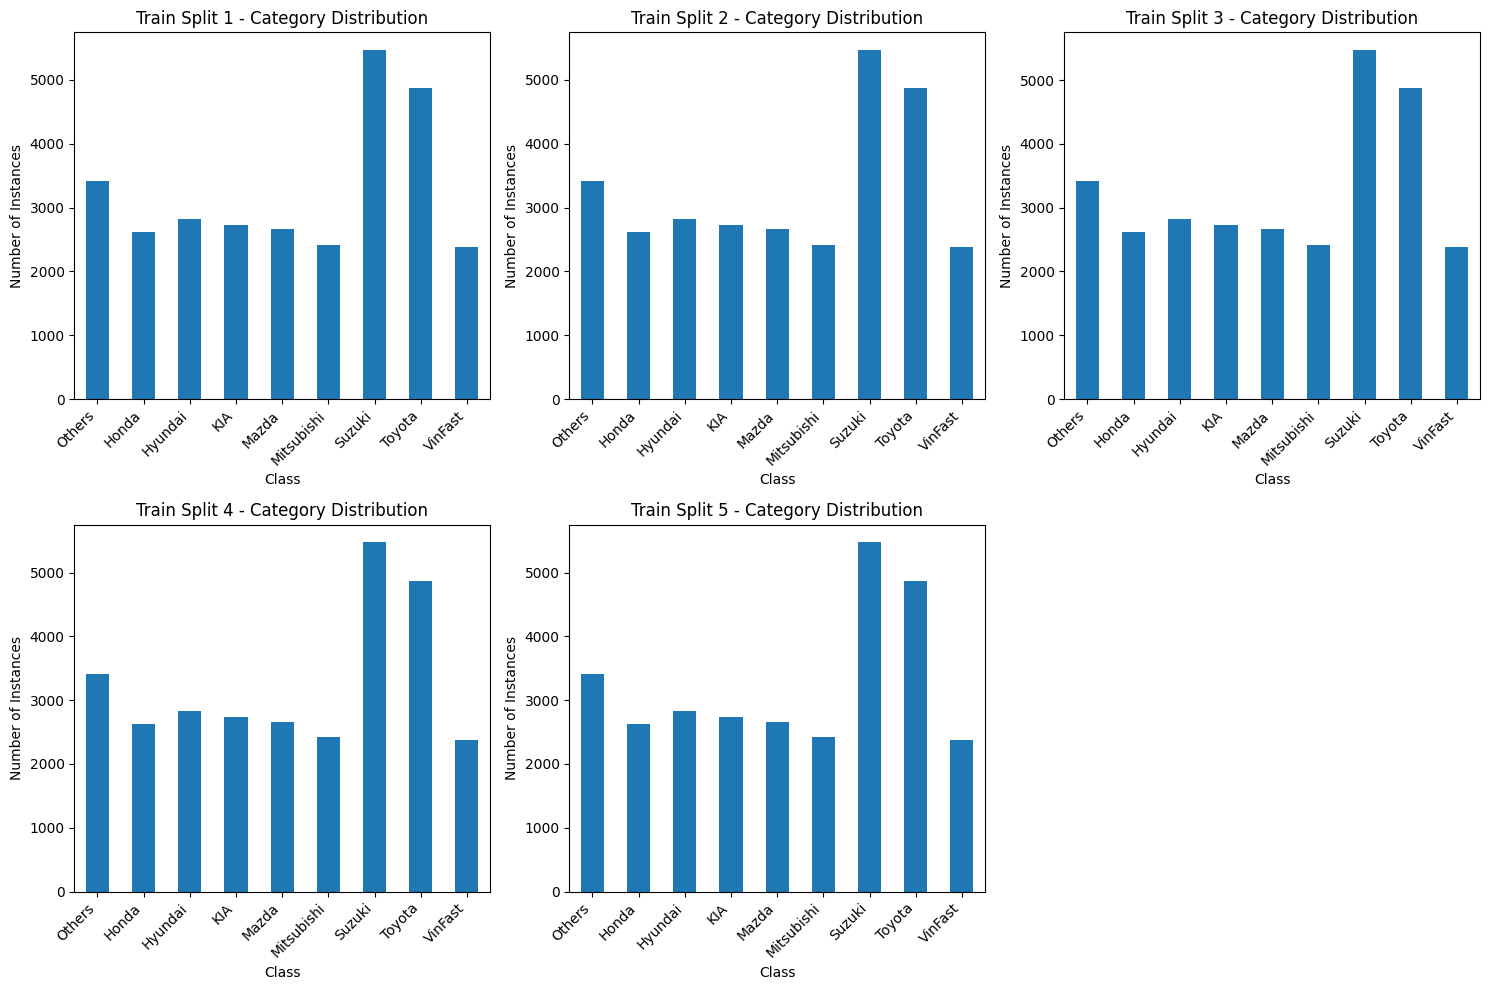

In [17]:
reverse_categories = {v: k for k, v in splitter.category_mapping.items()}

plt.figure(figsize=(15, 10))

for i in range(5):
    plt.subplot(2, 3, i+1)
    full_counts = train_dataframes[i]['category_id'].value_counts()

    # Sắp xếp theo thứ tự category_id
    sorted_index = sorted(full_counts.index, key=lambda x: x)
    full_counts = full_counts.loc[sorted_index]

    full_counts.plot(kind='bar',
                     title=f'Train Split {i+1} - Category Distribution')

    # Đặt lại tên nhãn
    plt.gca().set_xticklabels([reverse_categories.get(x, f"Unknown {x}") for x in full_counts.index])

    plt.xlabel('Class')
    plt.ylabel('Number of Instances')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [18]:
from IPython.display import display

test_dataframes = []

for i in range(1, 6):
    df_test = pd.read_csv(f'/kaggle/input/car-cs114/car_split/car_split/CarDataset-Splits-{i}-Test.csv')
    df_test.columns = ['image_dir', 'category_id']
    test_dataframes.append(df_test)

    print(f"\nCarDataset-Splits-{i}-Test")
    display(df_test)


CarDataset-Splits-1-Test


image_dir  category_id
0               Others/22521070-22520211.Others.255.jpg            0
1                Others/22520394-22520395.Others.81.jpg            0
2               Others/22520779-22521587.Others.653.jpg            0
3                Others/22520521-22520884.Others.10.jpg            0
4               Others/22520779-22521587.Others.837.jpg            0
...                                                 ...          ...
7345  VinFast/22521027-22520195-22521060.VinFast.112...            8
7346  VinFast/22521027-22520195-22521060.VinFast.077...            8
7347  VinFast/22521027-22520195-22521060.VinFast.006...            8
7348           VinFast/21522373-21522499.VinFast.43.jpg            8
7349          VinFast/22521070-22520211.VinFast.177.jpg            8

[7350 rows x 2 columns]


CarDataset-Splits-2-Test


image_dir  category_id
0               Others/22520394-22520395.Others.547.jpg            0
1               Others/22521070-22520211.Others.166.jpg            0
2               Others/22520779-22521587.Others.527.jpg            0
3                Others/22521070-22520211.Others.97.jpg            0
4      Others/22521027-22520195-22521060.Others.888.jpg            0
...                                                 ...          ...
7345  VinFast/22521027-22520195-22521060.VinFast.044...            8
7346   VinFast/22521465-22520811-22520683.VinFast.8.jpg            8
7347  VinFast/22521027-22520195-22521060.VinFast.060...            8
7348  VinFast/22520459-22520507-22520862.VinFast.34.jpg            8
7349            VinFast/22521692-22521676.VinFast.7.jpg            8

[7350 rows x 2 columns]


CarDataset-Splits-3-Test


image_dir  category_id
0               Others/22520394-22520395.Others.181.jpg            0
1       Others/22521027-22520195-22521060.Others.43.jpg            0
2               Others/22520779-22521587.Others.584.jpg            0
3               Others/22521492-22521599.Others.137.jpg            0
4               Others/22520779-22521587.Others.977.jpg            0
...                                                 ...          ...
7342          VinFast/22521342-22520970.VinFast.184.jpg            8
7343           VinFast/22521560-22521614.VinFast.23.jpg            8
7344           VinFast/21522373-21522499.VinFast.10.png            8
7345  VinFast/22521259-22521213-22521463.VinFast.13.jpg            8
7346  VinFast/22521027-22520195-22521060.VinFast.092...            8

[7347 rows x 2 columns]


CarDataset-Splits-4-Test


image_dir  category_id
0       Others/22520459-22520507-22520862.Others.23.jpg            0
1      Others/22521027-22520195-22521060.Others.307.jpg            0
2               Others/22521586-22521559.Others.169.jpg            0
3              Others/22520779-22521587.Others.1013.jpg            0
4               Others/22520394-22520395.Others.265.jpg            0
...                                                 ...          ...
7342          VinFast/22521342-22520970.VinFast.209.jpg            8
7343  VinFast/22521027-22520195-22521060.VinFast.031...            8
7344  VinFast/22521027-22520195-22521060.VinFast.082...            8
7345  VinFast/22521027-22520195-22521060.VinFast.018...            8
7346          VinFast/22521070-22520211.VinFast.167.jpg            8

[7347 rows x 2 columns]


CarDataset-Splits-5-Test


image_dir  category_id
0               Others/22520394-22520395.Others.578.jpg            0
1               Others/22521586-22521559.Others.189.jpg            0
2      Others/22521027-22520195-22521060.Others.443.jpg            0
3               Others/22520779-22521587.Others.716.jpg            0
4       Others/22521027-22520195-22521060.Others.50.jpg            0
...                                                 ...          ...
7338  VinFast/22520683-22520811-22521465.VinFast.27.jpg            8
7339  VinFast/22521027-22520195-22521060.VinFast.115...            8
7340            VinFast/22521560-22521614.VinFast.4.jpg            8
7341          VinFast/22521070-22520211.VinFast.185.jpg            8
7342  VinFast/22521027-22520195-22521060.VinFast.090...            8

[7343 rows x 2 columns]

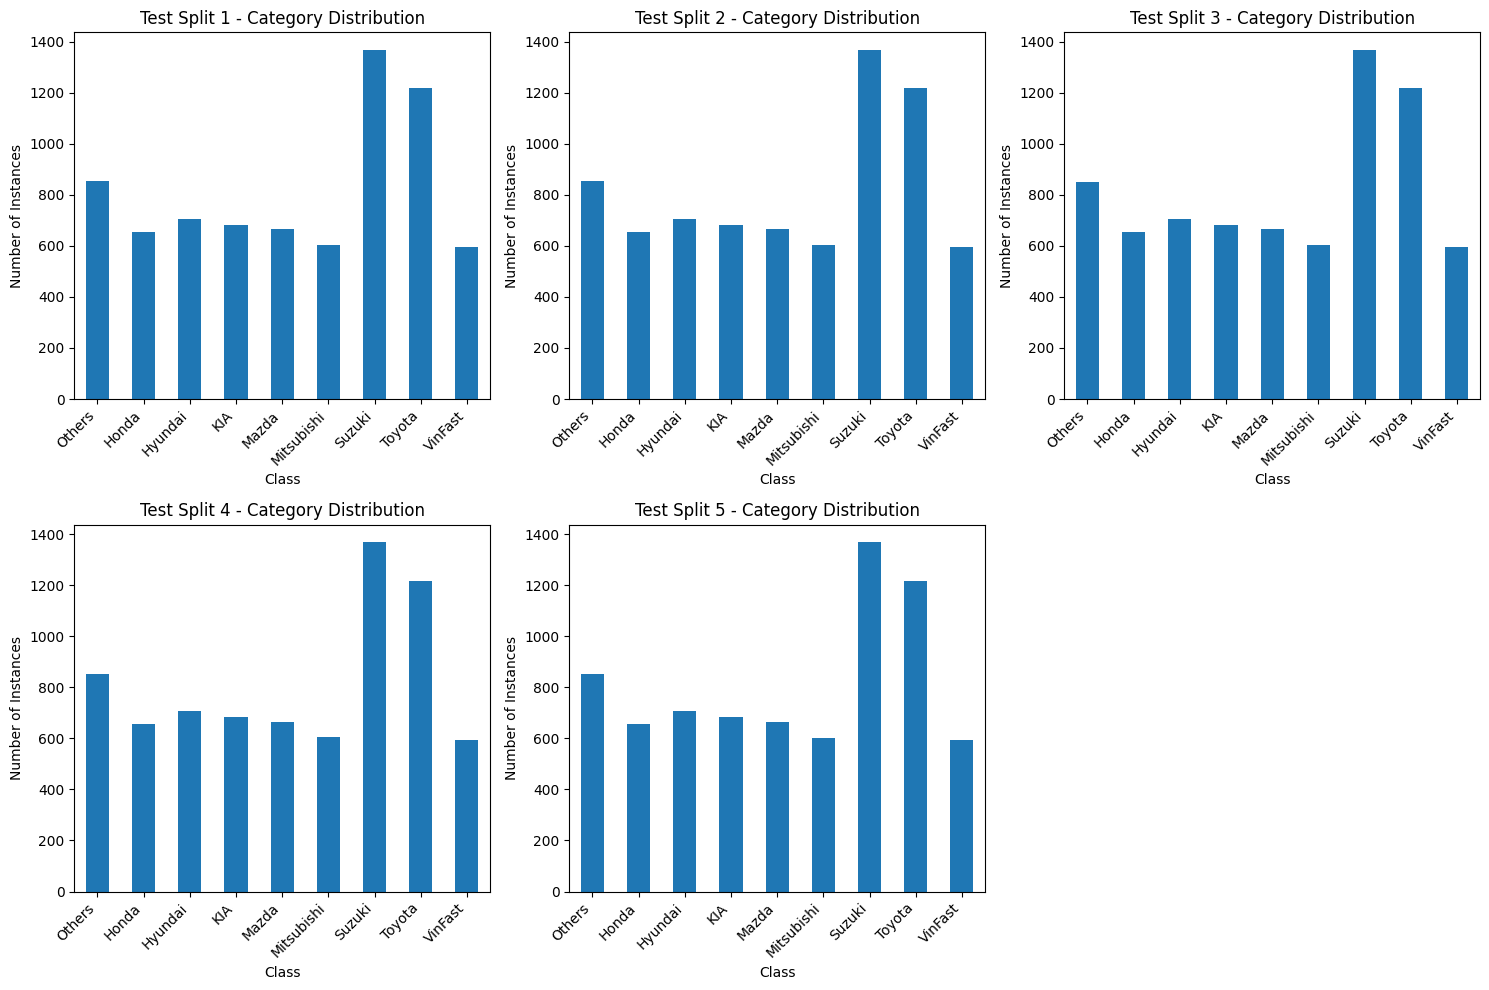

In [19]:
reverse_categories = {v: k for k, v in splitter.category_mapping.items()}

plt.figure(figsize=(15, 10))

for i in range(5):
    plt.subplot(2, 3, i+1)
    full_counts_2 = test_dataframes[i]['category_id'].value_counts()

    # Sắp xếp theo thứ tự category_id
    sorted_index_2 = sorted(full_counts_2.index, key=lambda x: x)
    full_counts_2 = full_counts_2.loc[sorted_index_2]

    full_counts_2.plot(kind='bar',
                     title=f'Test Split {i+1} - Category Distribution')

    # Đặt lại tên nhãn
    plt.gca().set_xticklabels([reverse_categories.get(x, f"Unknown {x}") for x in full_counts_2.index])

    plt.xlabel('Class')
    plt.ylabel('Number of Instances')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()